In [5]:
import copy

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import simpson, quad

from solaroid.simulate import invt_sample_z
from solaroid.likelihood import ln_normal, ln_two_sech2
from solaroid.integrate import log_simpson
from solaroid.gram_schmidt import gram_schmidt

In [6]:
pars = {
    'h1': 120, 
    'h2': 400, 
    'f': 0.75
}

---

# The numerical way

Pre-compute integrals:

In [7]:
def test_vector_ip(obj1, obj2):
    return np.dot(obj1, obj2)

In [8]:
# basis_vecs = gram_schmidt([], test_vector_ip)
# basis_vecs = gram_schmidt([np.array([1, 3, 4.]), np.polynomial.Polynomial.basis(1)], 
#                           test_vector_ip)

def func(z, n):
    return np.polynomial.Polynomial.basis(n)(z)

basis_vecs = gram_schmidt([lambda z: func(z, 0), lambda z: func(z, 1), lambda z: func(z, 2)], 
                          test_vector_ip)

In [9]:
vecs = np.array([
    [1.4, 6.1, 3.3],
    [4.2, 3.3, 0.5],
    [11.3, 5, 3.]
])
basis_vecs = gram_schmidt(vecs, test_vector_ip)
print(basis_vecs)

for i, vec1 in enumerate(basis_vecs):
    for j, vec2 in enumerate(basis_vecs):
        assert np.isclose(vec1 @ vec2, int(i == j))

[array([0.19787121, 0.86215314, 0.46641071]), array([ 0.93267068, -0.01918324, -0.36021855]), array([ 0.30161629, -0.50628448,  0.80790076])]


In [10]:
def test_legendre_ip(f1, f2):
    grid = np.linspace(-1, 1, 1025)  # BOO YA
    return simpson(f1(grid) * f2(grid) / 2, x=grid)

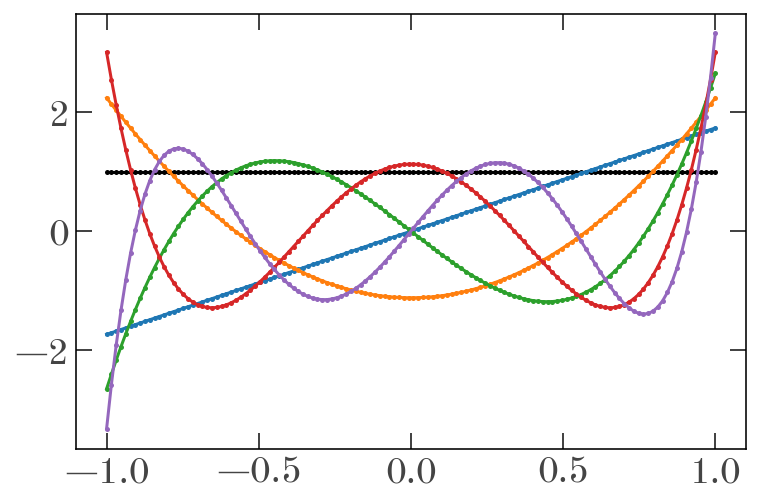

In [11]:
funcs = [np.polynomial.Polynomial.basis(deg) for deg in range(6)]
basis_funcs = gram_schmidt(funcs, test_legendre_ip)

grid = np.linspace(-1, 1, 128)
for func in basis_funcs:
    plt.plot(grid, func(grid))

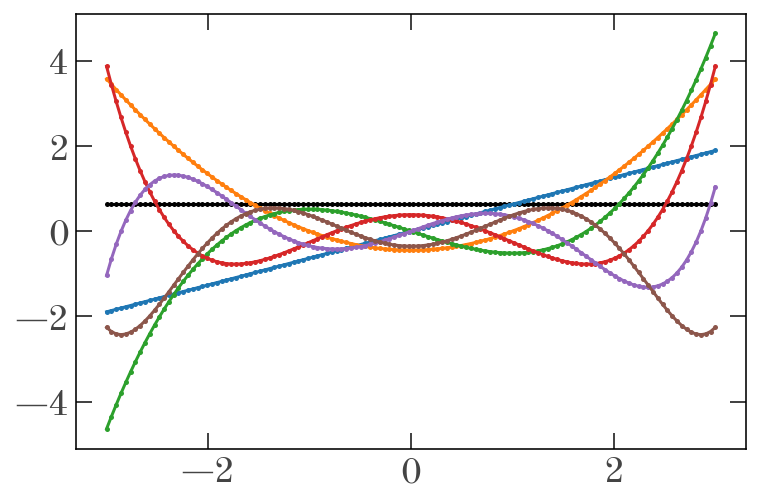

In [12]:
def test_hermite_ip(f1, f2):
    grid = np.linspace(-10, 10, 1025)  # BOO YA
    return simpson(f1(grid) * f2(grid) * np.exp(-grid**2 / 2), x=grid)

funcs = [np.polynomial.Polynomial.basis(deg) for deg in range(7)]
basis_funcs = gram_schmidt(funcs, test_hermite_ip)

grid = np.linspace(-3, 3, 128)
for func in basis_funcs:
    plt.plot(grid, func(grid))

In [13]:
from scipy.integrate import trapezoid

In [14]:
def test_func_ip(f1, f2, measure_func, grid, scale):
    # TODO: or use quad() with the function handle
    return simpson(f1(grid) * f2(grid) * measure_func(scale * grid) * scale,
                   x=grid)
#     return trapezoid(f1(grid) * f2(grid) * measure_func(grid),
#                      x=grid)


def test_func_ip_quad(f1, f2, measure_func, scale):
    return quad(lambda z: f1(z) * f2(z) * measure_func(scale * z) * scale, -np.inf, np.inf)[0]

In [15]:
funcs = [np.polynomial.Polynomial.basis(deg) for deg in range(15)]

measure_func = lambda z: np.exp(ln_two_sech2(z, **pars))
grid = np.arctanh(np.linspace(-1+1e-8, 1-1e-8, 8192))

# sech2_basis_funcs = gram_shit(funcs, test_func_ip, args=(measure_func, grid, pars['h2']))
sech2_basis_funcs = gram_schmidt(funcs, test_func_ip_quad, args=(measure_func, pars['h2']))

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:16: RuntimeWarning: overflow encountered in cosh
  lnterm1 = np.log(f) - 2 * np.log(np.cosh(z / (2 * h1))) - np.log(4 * h1)
/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:17: RuntimeWarning: overflow encountered in cosh
  lnterm2 = np.log(1 - f) - 2 * np.log(np.cosh(z / (2 * h2))) - np.log(4 * h2)


In [16]:
sech2_basis_funcs[8]

Polynomial([ 1.76496730e-01,  0.00000000e+00, -3.58835559e-01,  0.00000000e+00,
        2.62440636e-02,  0.00000000e+00, -3.61081615e-04,  0.00000000e+00,
        1.05610033e-06], domain=[-1.,  1.], window=[-1.,  1.])

(-5.0, 5.0)

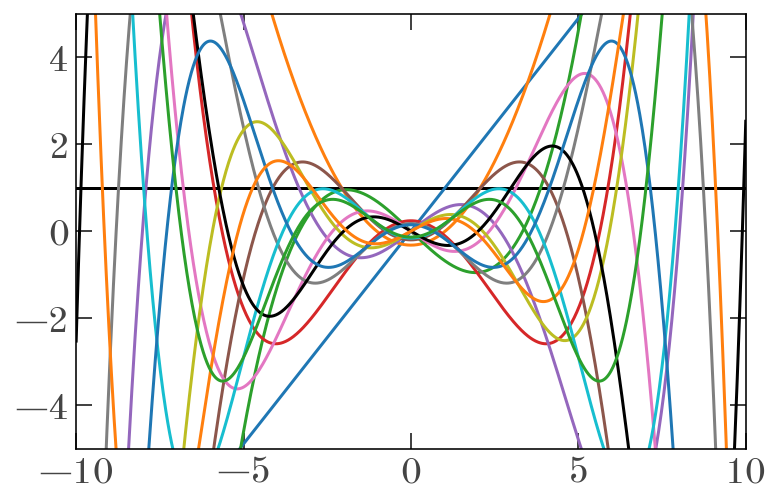

In [17]:
plot_grid = np.linspace(-10, 10, 1024)
for func in sech2_basis_funcs:
    plt.plot(plot_grid, func(plot_grid), marker='')
# plt.xlim(-5000, 5000)
plt.xlim(-10, 10)
plt.ylim(-5, 5)

Text(0.5, 0, '$z$ [kpc]')

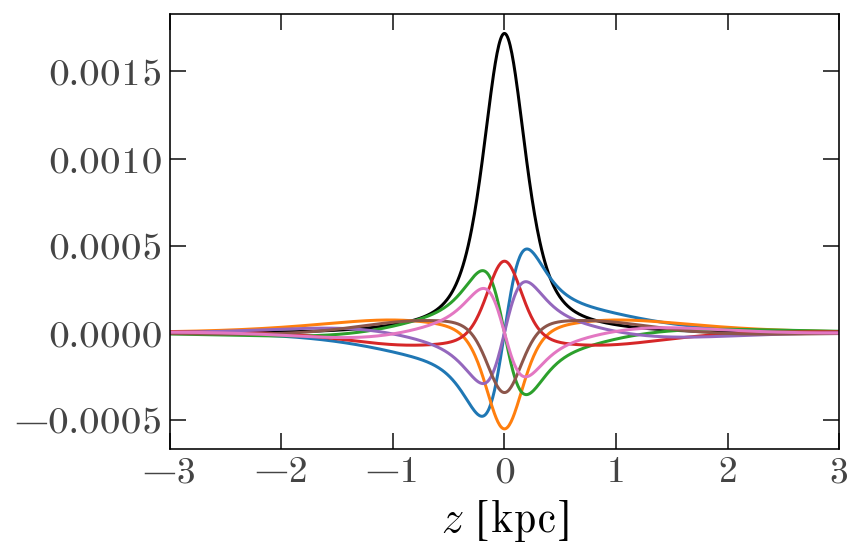

In [18]:
plot_grid = np.linspace(-10, 10, 1024)
for func in sech2_basis_funcs[:8]:
    plt.plot(
        plot_grid * pars['h2'] / 1e3, 
        func(plot_grid) * measure_func(plot_grid * pars['h2']), 
        marker=''
    )
# plt.xlim(-5000, 5000)
plt.xlim(-3, 3)
plt.xlabel('$z$ [kpc]')

---

# The analytic way

See the `Orthogonal-basis.nb` mathematica notebook.

Term 0:
$$
\begin{align}
f_0(z) &= a_{00}\\
\int \textrm{d}z \, f_0(z)^2 \, \rho(z) &= 1\\
\int \textrm{d}z \, a_{00}^2 \, \rho(z) &= 1\\
\end{align}
$$
so $a_{00}=1$

---

Term 1:
$$
\begin{align}
f_1(z) &= a_{10} + a_{11} \, z\\
\int \textrm{d}z \, f_1(z)^2 \, \rho(z) &= 1\\
\int \textrm{d}z \, f_0(z) \, f_1(z) \, \rho(z) &= 0\\
\end{align}
$$

Mathematica says: 
$$
\begin{align}
a_{10} &= 0\\
a_{11} &= \frac{\sqrt{3}}{\pi} \, \left( h_2^2 + f\, (h_1 - h_2)\,(h_1 + h_2) \right)^{-1/2}
\end{align}
$$

---

Term 2:
$$
\begin{align}
f_2(z) &= a_{20} + a_{21} \, z + a_{22} \, z^2\\
\int \textrm{d}z \, f_2(z)^2 \, \rho(z) &= 1\\
\int \textrm{d}z \, f_0(z) \, f_2(z) \, \rho(z) &= 0\\
\int \textrm{d}z \, f_1(z) \, f_2(z) \, \rho(z) &= 0\\
\end{align}
$$

Mathematica says:
$$
\begin{align}
a_{20} &= \frac{1}{3}(-22\,f\,h_1^2\,\pi^2 - 22\,h_2^2\,\pi^2 + 22\,f\,h_2^2\,\pi^2)\\
a_{21} &= 0\\
a_{22} &= \textrm{huge expression}
\end{align}
$$

In [77]:
def ln_density(z, **kw):
    return ln_two_sech2(z, **kw)

In [87]:
def f1(z, h1, h2, f):
    return np.sqrt(3) / np.pi * (h2**2 + f*(h1-h2)*(h1+h2))**-0.5 * z

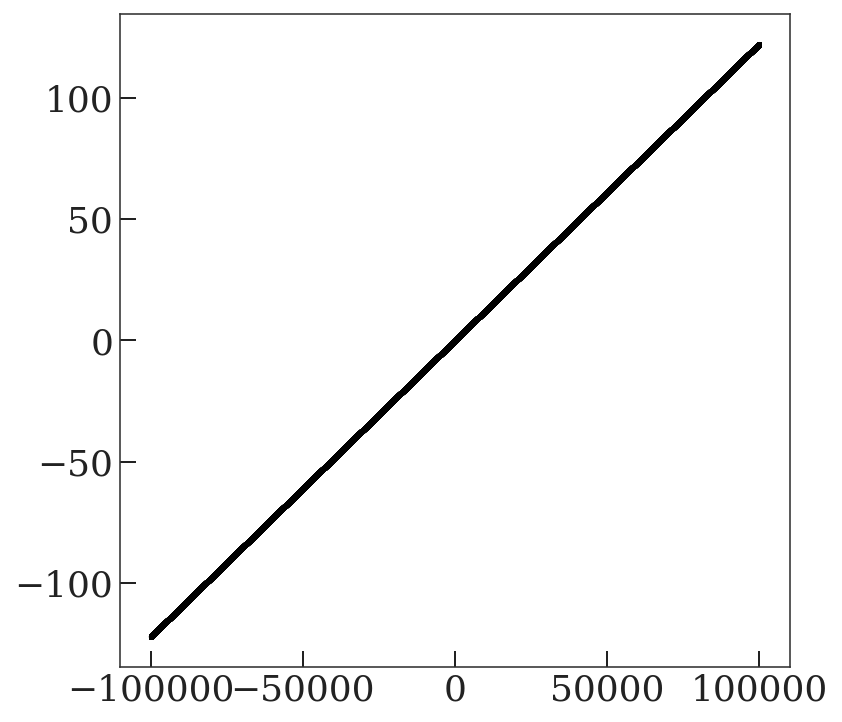

In [115]:
alpha = 0.5
zgrid = np.arange(-100, 100, 1e-3) * 1e3
ln_dens0 = ln_density(zgrid, **pars)
dens1 = f1(zgrid, **pars)
dens = alpha * np.exp(ln_dens0) + (1-alpha) * (dens1)

plt.plot(zgrid, dens)

In [126]:
zgrid = np.linspace(-1000, 1000, 1024)
simpson(f1(zgrid, **pars), x=zgrid)

0.0

In [121]:
from scipy.integrate import quad

In [123]:
quad(lambda z: f1(z, **pars), -100, 100)

(0.0, 2.705621306299946e-13)